# Identify Object Positions in Images - YOLO vs VLM 

---

Consider the image: `/images/table_scene.jpeg`.

### TASK
Detect the cup on the table and identify it visually by **drawing a bounding box around it on the image itself**.  
You can do this using the provided `utils` functions, or by writing your own.

### Models to Compare
Compare the performance of these three models:

1. **YOLO**
2. **GPT-4.1-mini**
3. **Gemini 2.5-flash**

### Notes
Depending on your prompt choice and the model’s output format, you may need to:

- update the `utils` functions, or  
- adapt your code to make it compatible (e.g., **parsing outputs** that come back as text vs JSON).

---


### Utils 
Some of the utils are taken and modified for the purpose of the exercise from 
https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=wizbxA1lm-Tj
https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb#scrollTo=245bc92a470f


In [1]:
import json
import re
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

#this function is needed to plot bounding boxes on images 
def plot_bounding_boxes(im, positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, ((y1, x1, y2, x2)) in enumerate(positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        #draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# if the boxes coordinates are output not as json but as text, should be parsed first
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result



# YOLO

In [6]:
# Import YOLO and load a pre-trained model
from ultralytics import YOLO
import cv2

# Load the YOLOv8 pre-trained model
model = YOLO('yolov8n.pt')  # nano model for quick inference

# Run inference on a sample image

results = model('/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg', save = False)  # Displays image with detections

for result in results:
    print(result.boxes)  # Boxes object for bounding box outputs



image 1/1 /workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg: 640x640 1 cup, 2 potted plants, 2 dining tables, 4 books, 3 vases, 305.5ms
Speed: 14.0ms preprocess, 305.5ms inference, 36.1ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([41., 58., 75., 75., 60., 73., 58., 73., 60., 73., 75., 73.])
conf: tensor([0.8666, 0.7697, 0.7267, 0.7095, 0.6095, 0.6043, 0.5443, 0.4876, 0.3747, 0.3382, 0.2693, 0.2544])
data: tensor([[6.1529e+02, 5.5336e+02, 8.4596e+02, 7.8049e+02, 8.6657e-01, 4.1000e+01],
        [3.8491e+02, 8.2020e+01, 5.8930e+02, 3.5290e+02, 7.6967e-01, 5.8000e+01],
        [7.2199e+02, 3.9503e+02, 9.6582e+02, 6.3202e+02, 7.2675e-01, 7.5000e+01],
        [6.1139e+02, 3.5216e+02, 7.2161e+02, 5.2007e+02, 7.0952e-01, 7.5000e+01],
        [0.0000e+00, 3.7149e+02, 1.0240e+03, 1.0240e+03, 6.0951e-01, 6.0000e+01],
        [8.7753e+01, 4.1335e+02, 4.2453e+02, 5.5627e+02, 6.0427e-01, 7.3000e+01],
       

In [8]:
# Predict with the model
results = model.predict("/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg", conf=0.75) #check params if you need to improve detection


image 1/1 /workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg: 640x640 1 cup, 1 potted plant, 163.0ms
Speed: 3.8ms preprocess, 163.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

image = Image.open("/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg")

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")


text_labels = [["Cup"]]

inputs = processor(text=text_labels, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(image.height, image.width)])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
)

In [11]:
# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]

In [14]:
def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for i, box in enumerate(boxes):
        box = [round(i, 2) for i in box.tolist()]
        show_box(box, plt.gca())
        plt.text(
            x=box[0],
            y=box[1] - 12,
            s=f"{labels[i]}: {scores[i]:,.4f}",
            c="beige",
            path_effects=[pe.withStroke(linewidth=4, foreground="darkgreen")],
        )
    plt.axis("on")
    plt.show()

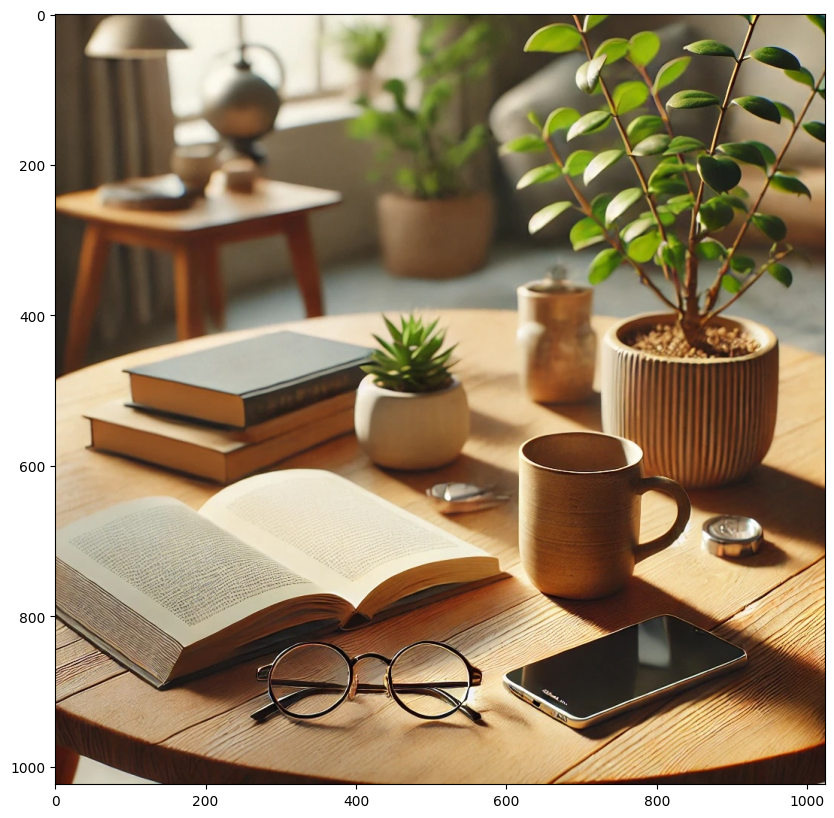

In [15]:
image = Image.open("/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg")
show_boxes_and_labels_on_image(
    image,
    boxes,
    text_labels,
    scores
)